<h1>I. Prétraitement des données :</h1>

1. Importation des librairies et chargement des données

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Chargement du dataset
data = pd.read_csv('CC GENERAL.csv')  
print(data.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

2. Nettoyage des données

In [14]:
# Suppression de la colonne d'ID (inutile pour le clustering)
data = data.drop('CUST_ID', axis=1)

# Détection des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(data.isnull().sum())

# Imputation des valeurs manquantes par la médiane (robuste aux outliers)
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
print("\nAprès imputation :")
print(data_imputed.isnull().sum())

Valeurs manquantes par colonne :
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Après imputation :
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY       

3. Normalisation des données

In [15]:
# Standardisation (moyenne=0, écart-type=1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
print("\nDonnées standardisées :")
print(data_scaled.describe().round(2))


Données standardisées :
       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
count  8950.00            8950.00    8950.00           8950.00   
mean     -0.00               0.00       0.00             -0.00   
std       1.00               1.00       1.00              1.00   
min      -0.75              -3.70      -0.47             -0.36   
25%      -0.69               0.05      -0.45             -0.36   
50%      -0.33               0.52      -0.30             -0.33   
75%       0.24               0.52       0.05             -0.01   
max       8.40               0.52      22.48             24.20   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count                 8950.00       8950.00              8950.00   
mean                     0.00         -0.00                 0.00   
std                      1.00          1.00                 1.00   
min                     -0.45         -0.47                -1.22   
25%                     -0.45         -0

4. Réduction de dimension (PCA)

Variance expliquée par les 2 composantes : 0.48


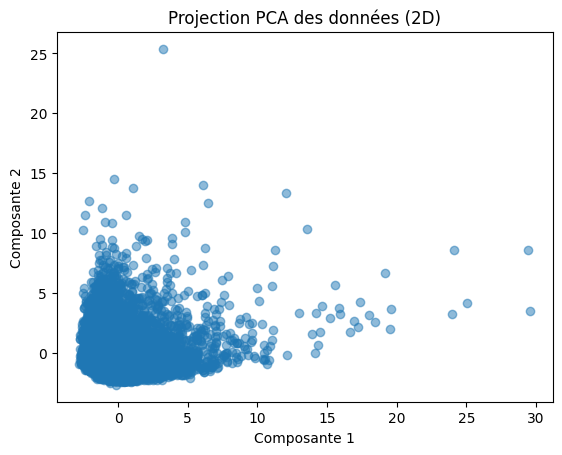

In [16]:
# Application de PCA pour visualisation
pca = PCA(n_components=2)  # Réduction en 2D pour visualisation
data_pca = pca.fit_transform(data_scaled)
print(f"Variance expliquée par les 2 composantes : {pca.explained_variance_ratio_.sum():.2f}")

# Visualisation des données en 2D
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.title('Projection PCA des données (2D)')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.show()

Analyse des corrélations

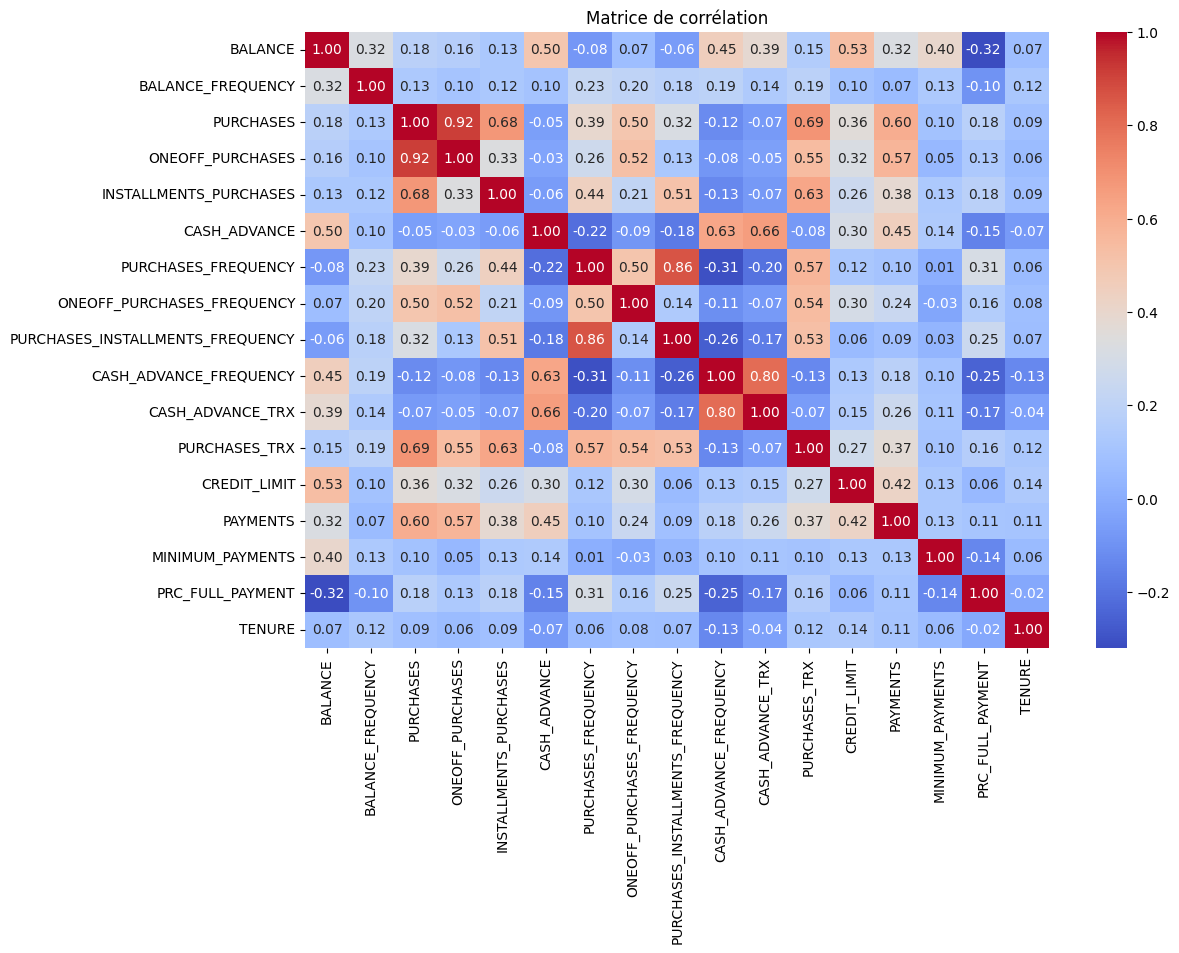

In [17]:
import seaborn as sns

# Matrice de corrélation
corr_matrix = data_imputed.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

<strong>Explications des étapes :</strong>

Suppression de CUST_ID : Les identifiants uniques ne sont pas pertinents pour le clustering.

Imputation par la médiane : Préserve la robustesse face aux outliers (fréquents dans les données financières).

Standardisation : Nécessaire pour les algorithmes comme K-means ou DBSCAN (sensibles aux échelles).

PCA : Réduit le bruit et permet une visualisation (optionnel pour le clustering final).


<strong>Résultat final :</strong>
data_scaled : Données prêtes pour le clustering (normalisées, sans valeurs manquantes).

data_pca : Version 2D pour exploration visuelle.

<h1>II. Méthodes de clustering évaluées :</h1>

1. Imports et données prétraitées

In [18]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import time
import numpy as np

2. K-means (Méthode du coude pour choisir K)

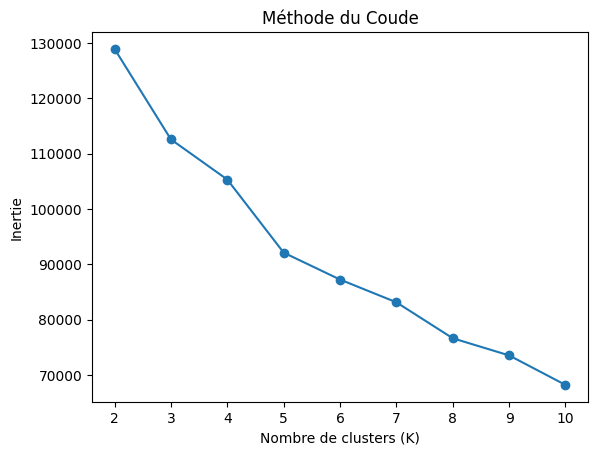

K-means - Silhouette Score: 0.19256596919095406
K-means - Davies-Bouldin: 1.4681616978769116
Temps d'exécution: 0.07s


In [19]:
# Méthode du coude pour trouver le meilleur K
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude')
plt.show()

# Clustering final avec le K optimal (ex: K=5)
kmeans = KMeans(n_clusters=5, random_state=42)
start_time = time.time()
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_time = time.time() - start_time

# Évaluation
print("K-means - Silhouette Score:", silhouette_score(data_scaled, kmeans_labels))
print("K-means - Davies-Bouldin:", davies_bouldin_score(data_scaled, kmeans_labels))
print(f"Temps d'exécution: {kmeans_time:.2f}s")

3. DBSCAN (Optimisation des paramètres)

In [20]:
# Optimisation de eps et min_samples (exemple avec eps=0.5, min_samples=10)
dbscan = DBSCAN(eps=0.5, min_samples=10)
start_time = time.time()
dbscan_labels = dbscan.fit_predict(data_scaled)
dbscan_time = time.time() - start_time

# Nombre de clusters (en ignorant le bruit -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN - Nombre de clusters: {n_clusters}")

# Évaluation (uniquement si au moins 2 clusters trouvés)
if n_clusters > 1:
    print("DBSCAN - Silhouette Score:", silhouette_score(data_scaled, dbscan_labels))
    print("DBSCAN - Davies-Bouldin:", davies_bouldin_score(data_scaled, dbscan_labels))
else:
    print("DBSCAN - Impossible à évaluer (trop peu de clusters)")
print(f"Temps d'exécution: {dbscan_time:.2f}s")

DBSCAN - Nombre de clusters: 9
DBSCAN - Silhouette Score: -0.2922332849916463
DBSCAN - Davies-Bouldin: 1.4862618264615768
Temps d'exécution: 0.67s


4. Gaussian Mixture Model (GMM)

In [21]:
# Choix du nombre de composantes (ex: 5)
gmm = GaussianMixture(n_components=5, random_state=42)
start_time = time.time()
gmm_labels = gmm.fit_predict(data_scaled)
gmm_time = time.time() - start_time

# Évaluation
print("GMM - Silhouette Score:", silhouette_score(data_scaled, gmm_labels))
print("GMM - Davies-Bouldin:", davies_bouldin_score(data_scaled, gmm_labels))
print(f"Temps d'exécution: {gmm_time:.2f}s")

GMM - Silhouette Score: 0.07116966655404822
GMM - Davies-Bouldin: 2.6239737994167536
Temps d'exécution: 2.80s


5. Agglomerative Hierarchical Clustering (MH)

In [22]:
# Clustering hiérarchique avec 5 clusters
agg = AgglomerativeClustering(n_clusters=5)
start_time = time.time()
agg_labels = agg.fit_predict(data_scaled)
agg_time = time.time() - start_time

# Évaluation
print("MH - Silhouette Score:", silhouette_score(data_scaled, agg_labels))
print("MH - Davies-Bouldin:", davies_bouldin_score(data_scaled, agg_labels))
print(f"Temps d'exécution: {agg_time:.2f}s")

MH - Silhouette Score: 0.17625723552382333
MH - Davies-Bouldin: 1.6479285547782812
Temps d'exécution: 8.07s


6. Visualisation des résultats (PCA 2D)

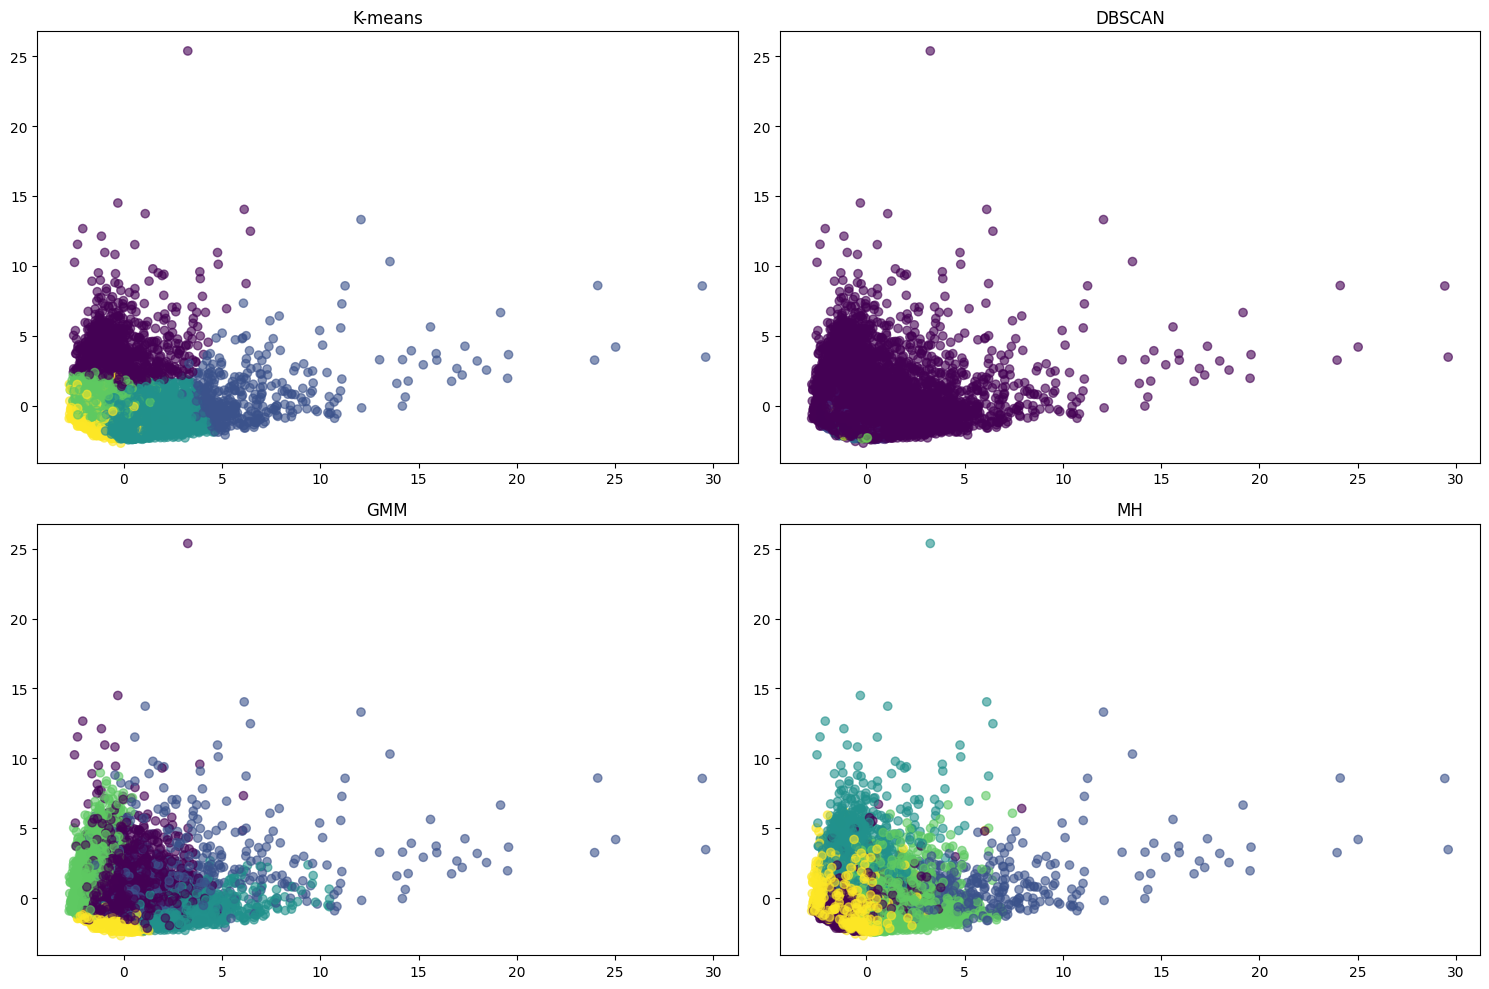

In [23]:
methods = {
    "K-means": kmeans_labels,
    "DBSCAN": dbscan_labels,
    "GMM": gmm_labels,
    "MH": agg_labels
}

plt.figure(figsize=(15, 10))
for i, (name, labels) in enumerate(methods.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(name)
plt.tight_layout()
plt.show()